# Simple code to extract gradcam

In [1]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# from torchvision.models import resnet18
# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define transforms
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Load CIFAR-10 dataset
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# # Load pre-trained ResNet-18
# model = resnet18(pretrained=True)
# model.fc = torch.nn.Linear(model.fc.in_features, 10)  # 10 classes for CIFAR-10
# model = model.to(device)
# model.eval()

# # Grad-CAM function
# class GradCAM:
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
#         self.gradients = None
#         self.activations = None
        
#         target_layer.register_forward_hook(self.save_activation)
#         target_layer.register_backward_hook(self.save_gradient)
    
#     def save_activation(self, module, input, output):
#         self.activations = output
    
#     def save_gradient(self, module, grad_input, grad_output):
#         self.gradients = grad_output[0]
    
#     def __call__(self, x):
#         self.model.zero_grad()
#         output = self.model(x)
        
#         class_idx = output.argmax().item()
#         output[0, class_idx].backward()
        
#         gradients = self.gradients.squeeze()
#         activations = self.activations.squeeze()
        
#         weights = gradients.mean(dim=(1, 2))
#         cam = (weights.view(-1, 1, 1) * activations).sum(dim=0)
        
#         cam = torch.relu(cam)
#         cam = cam / cam.max()
        
#         return cam.cpu().detach().numpy(), class_idx

# # Get a sample image
# dataiter = iter(testloader)
# image, label = next(dataiter)
# image = image.to(device)
# print(image.shape)

# # understanding feature shapes
# features = model(image)
# print(features.shape)

# # Compute Grad-CAM
# grad_cam = GradCAM(model, model.layer4[-1])
# cam, pred_class = grad_cam(image)
# print(cam.shape)

# # Resize CAM to match input image size
# cam_resized = Image.fromarray(cam).resize((224, 224), Image.BICUBIC)
# cam_resized = np.array(cam_resized)

# # CIFAR-10 classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# # Plot original image and Grad-CAM
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
# plt.title(f'Original Image (Label: {classes[label.item()]}, Pred: {classes[pred_class]})')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
# plt.imshow(cam_resized, cmap='jet', alpha=0.5)
# plt.title('Grad-CAM')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# Loading Our data

In [2]:
import torch

from dataset import StanfordDogsDataset

from torch.utils.data import DataLoader
from torchvision import transforms

DATA_DIR = "/home/localssk23/Downloads/ishika/data/DOGS"
BATCH_SIZE = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trans_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = StanfordDogsDataset(root_dir=DATA_DIR, dataset_type='test', transform=trans_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=BATCH_SIZE)


img1, img2, target1, target2, labels = next(iter(test_loader))

img1 = img1[5, ...]
img1 = img1.unsqueeze(0)
img1 = img1.to(device)
print(img1.shape)

torch.Size([1, 3, 224, 224])


In [3]:
from model import ClassificationBranch, UpperBranch, Backbone

import warnings
warnings.filterwarnings("ignore")

encoder_output_channels = 1024
flattened_encoder_output_size = 1024 * 49
num_classes = 5
    
classification_branch_model = ClassificationBranch(encoder_output_channels, flattened_encoder_output_size, num_classes)
classification_branch_model.load_state_dict(torch.load('weights/trained_classification_branch_indi_0.1_1-cos_d.pth'))

upper_branch_model = UpperBranch(encoder_output_channels)
upper_branch_model.load_state_dict(torch.load('weights/trained_upper_branch_indi_0.1_1-cos_d.pth'))
# upper_branch_model.load_state_dict(torch.load('weights/trained_upper_branch_indi_0.1_1-cos_d.pth'))

<All keys matched successfully>

In [4]:
import torch.nn as nn

backbone = Backbone().to(device)
features = backbone(img1.cuda())

classification_branch_model = classification_branch_model.to(device)
classification_branch_features, cls_output = classification_branch_model(features)
resized_classification_features = nn.functional.interpolate(classification_branch_features, size=(224, 224), mode='bilinear', align_corners=False)
print('Class:', cls_output)

upper_branch_model = upper_branch_model.to(device)
f, upper_branch_features1, upper_branch_features2 = upper_branch_model(features, features)
resized_upper_branch_features1 = nn.functional.interpolate(upper_branch_features1, size=(224, 224), mode='bilinear', align_corners=False)
resized_upper_branch_features2 = nn.functional.interpolate(upper_branch_features2, size=(224, 224), mode='bilinear', align_corners=False)

Class: tensor([[-0.5770, -0.9595,  0.8107,  0.4266, -0.0115]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


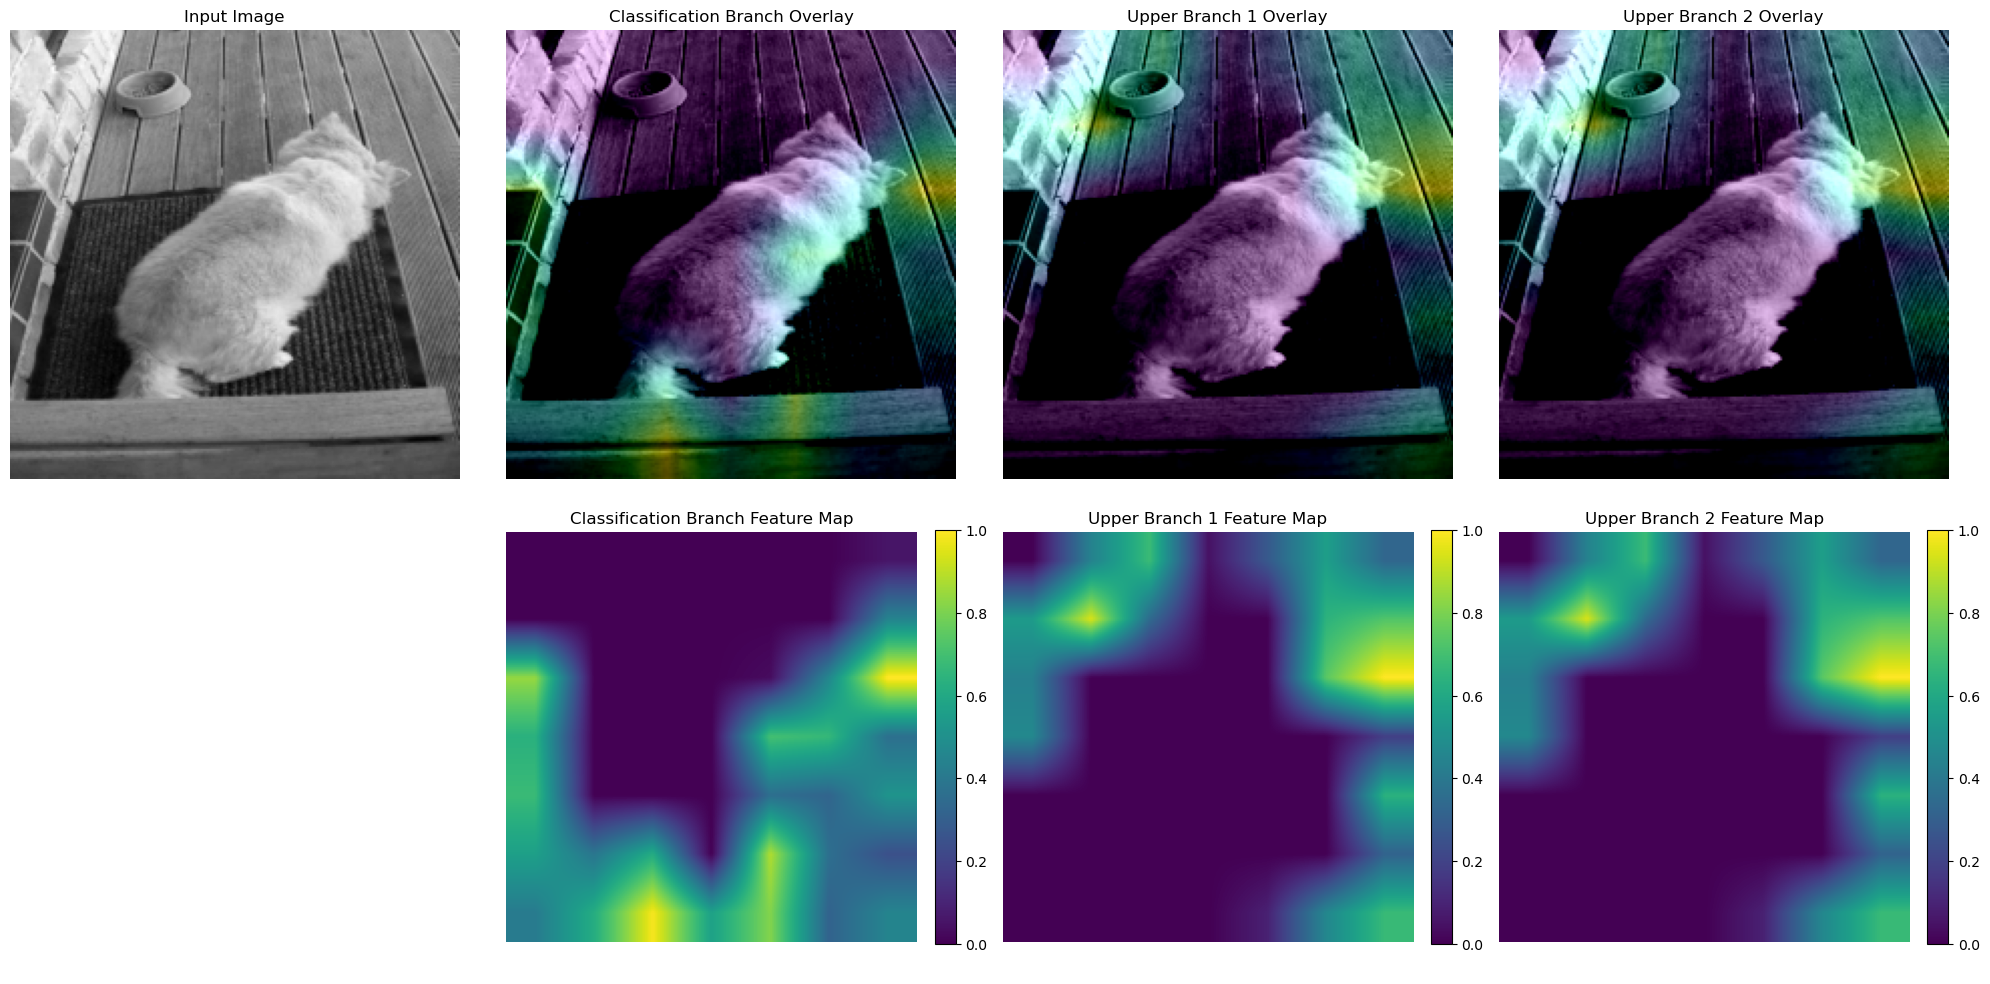

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the previous code for model processing remains the same

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# Display input image
ax[0, 0].imshow(img1[0, 0].cpu().detach().numpy(), cmap='gray')
ax[0, 0].set_title('Input Image')
ax[0, 0].axis('off')

# Remove the empty subplot below the input image
ax[1, 0].axis('off')

feature_maps = [
    resized_classification_features,
    resized_upper_branch_features1,
    resized_upper_branch_features2
]

titles = [
    'Classification Branch',
    'Upper Branch 1',
    'Upper Branch 2'
]

for i, (feature_map, title) in enumerate(zip(feature_maps, titles)):
    # Overlay resized features on input image
    input_img = img1[0, 0].cpu().detach().numpy()
    feature_img = feature_map[0, 0].cpu().detach().numpy()

    # Normalize feature image to [0, 1] range
    feature_img = (feature_img - feature_img.min()) / (feature_img.max() - feature_img.min())

    # Create RGB version of input image
    input_rgb = np.stack([input_img] * 3, axis=-1)

    # Create colored feature image
    feature_colored = plt.cm.viridis(feature_img)[:, :, :3]

    # Blend images
    alpha = 0.6  # Adjust this value to change the blend strength
    blended = alpha * feature_colored + (1 - alpha) * input_rgb

    # Plot overlay
    ax[0, i+1].imshow(blended)
    ax[0, i+1].set_title(f'{title} Overlay')
    ax[0, i+1].axis('off')

    # Plot feature map
    im = ax[1, i+1].imshow(feature_img, cmap='viridis')
    ax[1, i+1].set_title(f'{title} Feature Map')
    ax[1, i+1].axis('off')
    
    # Add colorbar
    plt.colorbar(im, ax=ax[1, i+1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Simple code to extract saliency

In [6]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# from torchvision.models import resnet18
# import matplotlib.pyplot as plt

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define transforms
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# # Load MNIST dataset
# testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# # Load pre-trained ResNet-18
# model = resnet18(pretrained=True)
# model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model = model.to(device)
# model.eval()

# # Function to compute saliency map
# def compute_saliency_map(model, image):
#     image.requires_grad_()
    
#     output = model(image)
#     output_idx = output.argmax()
#     output_max = output[0, output_idx]
    
#     output_max.backward()
    
#     saliency, _ = torch.max(image.grad.data.abs(), dim=1)
#     return saliency

# # Get a sample image
# dataiter = iter(testloader)
# image, label = next(dataiter)
# image = image.to(device)

# # Compute saliency map
# saliency = compute_saliency_map(model, image)

# # Plot original image and saliency map
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(image.cpu().squeeze().detach().numpy(), cmap='gray')
# plt.title(f'Original Image (Label: {label.item()})')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(saliency.cpu().squeeze().numpy(), cmap='hot')
# plt.title('Saliency Map')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# Issues with existing Code

combined_model definition is absent

In [7]:
from turtle import up
from model import ClassificationBranch,Backbone,UpperBranch
import torch
import torch.nn as nn
import numpy as np

import cv2

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50




def read_image(image_path):
	image = cv2.imread(image_path)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	
	image = cv2.resize(image, (224, 224))
	rgb_image = image.copy()
	rgb_image = rgb_image / 255.0
	image = np.transpose(image, (2, 0, 1))
	image = image / 255.0
	image = np.expand_dims(image, axis=0)
	image_tensor = torch.tensor(image, dtype=torch.float32)
	return rgb_image, image_tensor


class CombinedClassifierModel(nn.Module):
	def __init__(self, backbone, classifier):
		super(CombinedClassifierModel, self).__init__()
		self.backbone = backbone
		self.classifier = classifier

	def forward(self, x):
		features = self.backbone(x)
		out = self.classifier(features)
		return out

def load_combined_classifier_model(backbone_path, classifier_path):
	encoder_output_channels = 1024  # 512 for DenseNet
	spatial_dim = 49  # 7 * 7 = 49 for DenseNet
	flattened_encoder_output_size = encoder_output_channels * spatial_dim
	num_classes = 5

	backbone = Backbone()
	backbone.load_state_dict(torch.load(backbone_path))
	backbone.eval()

	classifier = ClassificationBranch(encoder_output_channels, flattened_encoder_output_size, num_classes)
	classifier.load_state_dict(torch.load(classifier_path))
	classifier.eval()

	combined_classifier_model = CombinedClassifierModel(backbone, classifier)
	combined_classifier_model.eval()

	return combined_classifier_model





class CombinedUpperBranchModel(nn.Module):
	def __init__(self, backbone, upper_branch):
		super(CombinedUpperBranchModel(), self).__init__()
		self.backbone = backbone
		self.upper_branch = upper_branch

	def forward(self, x):
		features = self.backbone(x)
		out = self.upper_branch(features)
		return out

def load_combined_upper_model(backbone_path, upper_branch_path):
	encoder_output_channels = 1024  # 512 for DenseNet
	spatial_dim = 49  # 7 * 7 = 49 for DenseNet
	flattened_encoder_output_size = encoder_output_channels * spatial_dim
	num_classes = 5

	backbone = Backbone()
	backbone.load_state_dict(torch.load(backbone_path))
	backbone.eval()

	upper_branch = UpperBranch()(encoder_output_channels)
	upper_branch.load_state_dict(torch.load(classifier_path))
	upper_branch.eval()
	
	combined_upper_branch_model = CombinedUpperBranchModel(backbone, upper_branch)
	combined_upper_branch_model.eval()

	return combined_upper_branch_model


if __name__ == "__main__":



	backbone_path = "/home/localssk23/Downloads/ishika/weights/backbone_epoch_8.pt"
	classifier_path = "weights/classification_branch_epoch_10.pt"
	# uppper_branch_path = "checkpoints/trained_upper_branch_indi_0.1_1-cos_d.pth"
	# image_path = "/home/ishikaexp_copy/DFRFS/NearOoD/data/DOGS/Images/n02085620-Chihuahua/n02085620_199.jpg"

	combined_classifer_model = load_combined_classifier_model(backbone_path, classifier_path)
	combined_model = combined_classifer_model



	target_layers = [combined_model.classifier.conv_block]
	# rgb_image,input_tensor = read_image(image_path)
	rgb_image = img1[0, 0].cpu().detach().numpy()
	input_tensor = img1
	targets = None


	print(input_tensor.shape)
	# with GradCAM(model=combined_model, target_layers=target_layers) as cam:
	with AblationCAM(model=combined_model, target_layers=target_layers) as cam:
		grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
		grayscale_cam = grayscale_cam[0, :]
		print(grayscale_cam.shape)
		cv2.imshow("CAM", grayscale_cam)

		visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
		cv2.imshow("CAM", visualization)
		model_outputs = cam.outputs

		cv2.waitKey(0)


	# for name, param in model.named_parameters():
	# 	print(name, param.requires_grad)

	# print(model.conv_block)

	# model = resnet50(pretrained=True)
	# target_layers = [model.layer4[-1]]
	# rgb_image,input_tensor = read_image(image_path)

	# targets = [ClassifierOutputTarget(281)]

	# with GradCAM(model=model, target_layers=target_layers) as cam:
	# 	grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
	# 	grayscale_cam = grayscale_cam[0, :]
	# 	print(grayscale_cam.shape)
	# 	cv2.imshow("CAM", grayscale_cam)

	# 	visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
	# 	cv2.imshow("CAM", visualization)
	# 	model_outputs = cam.outputs

	# 	cv2.waitKey(0)

torch.Size([1, 3, 224, 224])


AttributeError: 'tuple' object has no attribute 'cpu'